# **All Imports**

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import os
import platform
from gensim.models.word2vec import Word2Vec
from gensim.models.phrases import Phrases, Phraser 
import gensim.downloader as gensim_api
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, Input, LSTM, Dense 
from tensorflow.keras.models import Model 
from tensorflow.keras.utils import to_categorical

# **All Initializations**

In [2]:
OS = platform.system()   # Operating System
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

# **All Globals**

In [3]:
pretrained_embeddings = False
benchmark = False
language = "italian" # english

# **All General Functions Definitions**

In [33]:
def explore_data(data): 
  print("\nHead of Data: \n", data.head())
  print("\nTail of Data: \n", data.tail())
  print("\nShape of Data: ", data.shape)
  print("\nInformation about Data: \n")
  try: 
    data.info()
  except: 
    pass
  print("\nTypes of Data attributes: \n")
  try: 
    data.dtypes
  except: 
    pass
  print("\nSummary of all numerical fields in the dataset: \n")
  try: 
    data.describe(include = [np.number])
  except: 
    pass
  print("\nSummary of all categorical fields in the dataset: \n")
  try: 
    data.describe(include = ['O'])
  except: 
    pass
  print("\nLoop Through Each Column and Check for nulls: \n")
  try: 
    for i in range(len(data.columns)):
        print(data.columns[i] + ": " + str(data[data.columns[i]].isna().sum()))
  except: 
    pass

def data_download(file_to_download, gdrive_code, OS, uncompress = True):
  if not os.path.exists(file_to_download):
    os.system('gdown --id "'+gdrive_code+'" --output '+file_to_download)
    if OS == "Linux" and uncompress:
        os.system('unzip -o -n "./'+file_to_download+'" -d "./"')
    return True
  else: 
    return None

# Plot the loss function chart
def plot_loss(history = None):
    plt.figure()												# generate a new window
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend(loc='upper right')
    plt.show(block=False)
    plt.pause(1)

# Plot the accuracy function chart
def plot_acc(history = None):
    plt.figure()												# generate a new window
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.legend(loc='upper left')
    plt.show(block=False)
    plt.pause(1)

# **Data Download**

In [5]:
if benchmark == True: 
  out = data_download("./News_Category_Dataset_v2.zip", "1O0JTnVgHcYppkR5hmj8sxkpgP4dI164C", OS)
  category_dicts = []
  with open('News_Category_Dataset_v2.json', mode='r', errors='ignore') as json_file:
      for dic in json_file:
          category_dicts.append(json.loads(dic))
else: 
  out = data_download("./tweetHashtah3Giu.zip", "1J2FodTnUeDURmg1I-4AQcbHE0XISILKf", OS)

In [6]:
out

True

# **Data Preprocessing**

In [7]:
if benchmark == True:
  data = pd.DataFrame(category_dicts)
  data = data[data["category"].isin(['ENTERTAINMENT','POLITICS','TECH'])][["category","headline"]]
  data = data.rename(columns={"category":"labels", "headline":"text"})
  data = data[['text', 'labels']]     # move cols
  explore_data(data)
else:
  data = pd.read_csv("./tweetHashtah3Giu.csv")
  explore_data(data)



Head of Data: 
                                                 TEXT       hashtag
0   mille scienziati russi a rischio espulsione e...         #Cern
1  una motovedetta libica avrebbe sparato colpi d...         #ANSA
2  la colpa ricadrà sui medici renderanno conto i...  #Risvegliati
3  buongiorno ecco àdioggi salari in cambio della...      #LaVerit
4  le armi inviate all per difendersi contro i ru...      #Ucraina

Tail of Data: 
                                                     TEXT       hashtag
24051   lavorare per la pace è un dovere continuerò a...      #Salvini
24052  salvini se aspettiamo il pd o qualcuno dei ste...   #UkraineWar
24053  oggi esce con una comunicazione funesta al suo...  #Rubrichette
24054  a venezia landini va fermata la guerra sta peg...       #LiveIn
24055  a venezia landini va fermata la guerra sta peg...       #LiveIn

Shape of Data:  (24056, 2)

Information about Data: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24056 entries, 0 to 24055
Data co

In [8]:
data

,TEXT,hashtag
0,mille scienziati russi a rischio espulsione e...,#Cern
1,una motovedetta libica avrebbe sparato colpi d...,#ANSA
2,la colpa ricadrà sui medici renderanno conto i...,#Risvegliati
3,buongiorno ecco àdioggi salari in cambio della...,#LaVerit
4,le armi inviate all per difendersi contro i ru...,#Ucraina
...,...,...
24051,lavorare per la pace è un dovere continuerò a...,#Salvini
24052,salvini se aspettiamo il pd o qualcuno dei ste...,#UkraineWar
24053,oggi esce con una comunicazione funesta al suo...,#Rubrichette
24054,a venezia landini va fermata la guerra sta peg...,#LiveIn


#**Data Exploration**

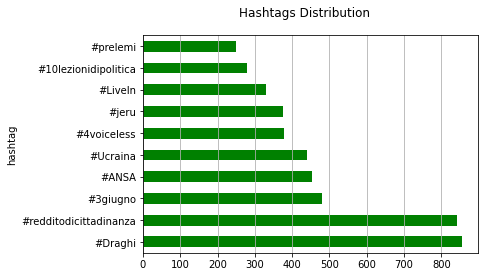

In [9]:
if benchmark == True: 
  fig, ax = plt.subplots()
  fig.suptitle("Dataset Distribution", fontsize=12)
  data["labels"].reset_index().groupby("labels").count().sort_values(by="index").plot(kind="barh", legend=False, ax=ax, color = "green").grid(axis='x')
  plt.show()
else:
  fig, ax = plt.subplots()
  fig.suptitle("Hashtags Distribution", fontsize=12)
  data["hashtag"].reset_index().groupby("hashtag").count().sort_values(by="index", ascending = False)[0:10].plot(kind="barh", legend=False, ax=ax, color = "green").grid(axis='x')
  ht = data["hashtag"].reset_index().groupby("hashtag").count().sort_values(by="index", ascending = False)[0:10]
  plt.show()
  filter = "$|".join(list(ht.index))
  data = data[data.hashtag.str.contains(filter)]
  data.hashtag.value_counts()
  data = data.rename(columns={"hashtag":"labels", "TEXT":"text"})



In [10]:
data.reset_index()

,index,text,labels
0,1,una motovedetta libica avrebbe sparato colpi d...,#ANSA
1,4,le armi inviate all per difendersi contro i ru...,#Ucraina
2,17,ieri c erano a roma i pescatori questo è lo sc...,#Draghi
3,27,a venezia mariastella gelmini prima il covid e...,#LiveIn
4,29,urgentissimo laura,#4voiceless
...,...,...,...
4680,24025,ucraina con la crisi del grano milioni di pers...,#ANSA
4681,24043,ieri c erano a roma i pescatori questo è lo sc...,#Draghi
4682,24050,a venezia landini va fermata la guerra sta peg...,#LiveIn
4683,24054,a venezia landini va fermata la guerra sta peg...,#LiveIn


# **Data Cleaning Function Definition**

In [11]:
def clean_text(text, stemming=False, remove_stopwords = True, lemmatization=True, language = language, print_stopwords = False):
  text = re.sub(r'[^\w\s]', '', str(text).lower().strip()) # (1)  
  lst_text = text.split()                                  # (2)
  if remove_stopwords: 
    lst_stopwords = nltk.corpus.stopwords.words(language)
    
    if lst_stopwords is not None:                          # (3)
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
    if print_stopwords: 
      print(lst_text)

  if stemming:                                             # (4)
      ps = nltk.stem.porter.PorterStemmer()
      lst_text = [ps.stem(word) for word in lst_text]
              
  if lemmatization:                                        # (5) 
      lem = nltk.stem.wordnet.WordNetLemmatizer()
      lst_text = [lem.lemmatize(word) for word in lst_text]
          
  text = " ".join(lst_text)                                # (6)
  
  return text

# **Data Cleaning**

In [12]:
data["text_clean"] = data["text"].apply(lambda x: clean_text(x, remove_stopwords = True, stemming=True, lemmatization=True)) 
explore_data(data)


Head of Data: 
                                                  text       labels  \
1   una motovedetta libica avrebbe sparato colpi d...        #ANSA   
4   le armi inviate all per difendersi contro i ru...     #Ucraina   
17  ieri c erano a roma i pescatori questo è lo sc...      #Draghi   
27  a venezia mariastella gelmini prima il covid e...      #LiveIn   
29                                urgentissimo laura   #4voiceless   

                                           text_clean  
1   motovedetta libica sparato colpi d arma fuoco ...  
4   armi inviat difendersi russi finiranno economi...  
17  ieri rom pescatori scenario vedremo sempr spes...  
27  venezia mariastella gelmini prima covid poi at...  
29                                 urgentissimo laura  

Tail of Data: 
                                                     text   labels  \
24025  ucraina con la crisi del grano milioni di pers...    #ANSA   
24043  ieri c erano a roma i pescatori questo è lo sc...  #Draghi   
24

# **Data Preparation**

In [13]:
train_set, test_set = train_test_split(data, test_size=0.2)
train_y = train_set["labels"].values
test_y = test_set["labels"].values

In [14]:
print(len(train_set))
print(len(test_set))
print(len(train_y))
print(len(test_y))

3748
937
3748
937


#**Embedding Layer with Gensim**

In [15]:
if pretrained_embeddings is True: 
  nlp = gensim_api.load("word2vec-google-news-300")
else: 
  corpus = train_set["text_clean"]

  # 1 - create list of lists of unigrams
  lst_corpus = []
  i = 0
  for string in corpus:
    lst_words = string.split()
    #print(lst_words)
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
    #print(lst_grams)
    lst_corpus.append(lst_grams)
    '''
    i+=1
    if i > 4: 
      break
    '''
    
  # 2 - create a list of bigrams and trigrams
  bigrams_detector = Phrases(lst_corpus, delimiter=" ".encode(), min_count=5, threshold=10)                     # Train a bigram model.
  bigrams_detector = Phraser(bigrams_detector)                                                                  # Export the trained model = use less RAM, faster processing
  trigrams_detector = Phrases(bigrams_detector[lst_corpus], delimiter=" ".encode(), min_count=5, threshold=10)  # Train a trigram model.
  trigrams_detector = Phraser(trigrams_detector)

In [16]:
print(type(lst_corpus))
print(type(bigrams_detector))
print(type(trigrams_detector))
print(len(lst_corpus))
print(lst_corpus)

<class 'list'>
<class 'gensim.models.phrases.Phraser'>
<class 'gensim.models.phrases.Phraser'>
3748
[['fare', 'sciacallaggio', 'attaccando', 'ragazza', 'mostra', 'vicinanza', 'esser', 'umano', 'lutto', 'qualifica', 'te', 'auguro', 'trovar', 'person', 'j', 'b', 'vita', 'trattino', 'evidentement', 'deve', 'esser', 'davvero', 'misera', 'comportarti', 'modo', 'così', 'meschino'], ['ucraina', 'distretto', 'mariupol', 'russi', 'imprigionando', 'sparando', 'volontari', 'funzionari', 'ucraini', 'rifiutati', 'collaborar', 'autorità', 'occupazion', 'fa', 'saper', 'mariupol', 'citi', 'council', 'citando', 'sindaco', 'vadym', 'boychenko'], ['ieri', 'rom', 'pescatori', 'scenario', 'vedremo', 'sempr', 'spesso', 'prossimi', 'mesi', 'gent', 'disperata', 'può', 'viver', 'proprio', 'lavoro', 'causa', 'politich', 'governo', 'caricata', 'polizia', 'abbandonata', 'destino'], ['leggo', 'solo', 'verità'], ['quando', 'parlato', 'ricominciato', 'auguri', 'minacc', 'mort', 'però', 'diamin', 'congiuntivo', 'altr

# **Word Embeddings Training by Gensim Word2Vec**

In [17]:
embedding_model = Word2Vec(lst_corpus, size=300, window=8, min_count=1, sg=1, iter=30)
if benchmark is True: 
  embedding_model.save("news_category_word2vec_embeddings.model")
else: 
  embedding_model.save("hashtags_word2vec_embeddings.model")

#**Language Model Sanity Check**

In [18]:
word = "guerra"
embedding_model[word].shape
print("Embeddings Coefficients for the word: ", word)
print("\n")
print(embedding_model[word])

Embeddings Coefficients for the word:  guerra


[-0.7222599   0.2372704   0.535793   -0.2948134   0.00945248 -0.65164906
  0.52871925  0.49959975 -0.05545426  0.01082973  0.02306649  0.48919088
  0.16714984  0.33881202 -0.21872064  0.20211865  0.77580553 -0.03725507
 -0.42967966 -0.42497805  0.53756475 -0.4367715  -0.20906557  0.12474653
  0.05881544 -0.04370344 -0.00518505  0.02808622  0.2937935  -0.2573858
  0.14887217  0.17857657  0.27839908  0.04682605 -0.03543914  0.20346656
 -0.24858862  0.26059788  0.19061781  0.08372146 -0.58917785 -0.07761856
 -0.03193767 -0.386696    0.1573803   0.09471831 -0.4047035  -0.5933536
 -0.2116255   0.55235475 -0.07464334 -0.08022391 -0.41027087 -0.04567583
  0.08320902 -0.20494953 -0.46938655  0.24116635  0.1570147  -0.09456845
  0.16196574 -0.006741   -0.01389188  0.6364884  -0.59017587 -0.02989429
  0.16120726 -0.2644945   0.16239555  0.0469267   0.10731155 -0.2196621
 -0.3023124   0.33957046 -0.5704412  -0.1128184   0.05437271  0.19173796
  0.87

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


#**Embedding Space Visualization Function**

In [19]:
def embedding_space_visualization(root_word, model, plot_3d = True, plot_2d = False):
  fig = plt.figure(figsize=(20, 17), dpi=80)
  tot_words = [word] + [tupla[0] for tupla in model.most_similar(word, topn=40)]   
  X = model[tot_words]
  if plot_3d: 
    pca = TSNE(perplexity=40, n_components=3, init='pca')                           

    X = pca.fit_transform(X)
    pca_data = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
    pca_data["input"] = 0
    pca_data["input"].iloc[0:1] = 1

    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pca_data[pca_data["input"]==0]['x'], pca_data[pca_data["input"]==0]['y'], pca_data[pca_data["input"]==0]['z'], c="black")
    ax.scatter(pca_data[pca_data["input"]==1]['x'], pca_data[pca_data["input"]==1]['y'], pca_data[pca_data["input"]==1]['z'], c="red")
    ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], yticklabels=[], zticklabels=[])
    for label, row in pca_data[["x","y","z"]].iterrows():
        x, y, z = row
        ax.text(x, y, z, s=label)

# **Plot the Embedding Space**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithC

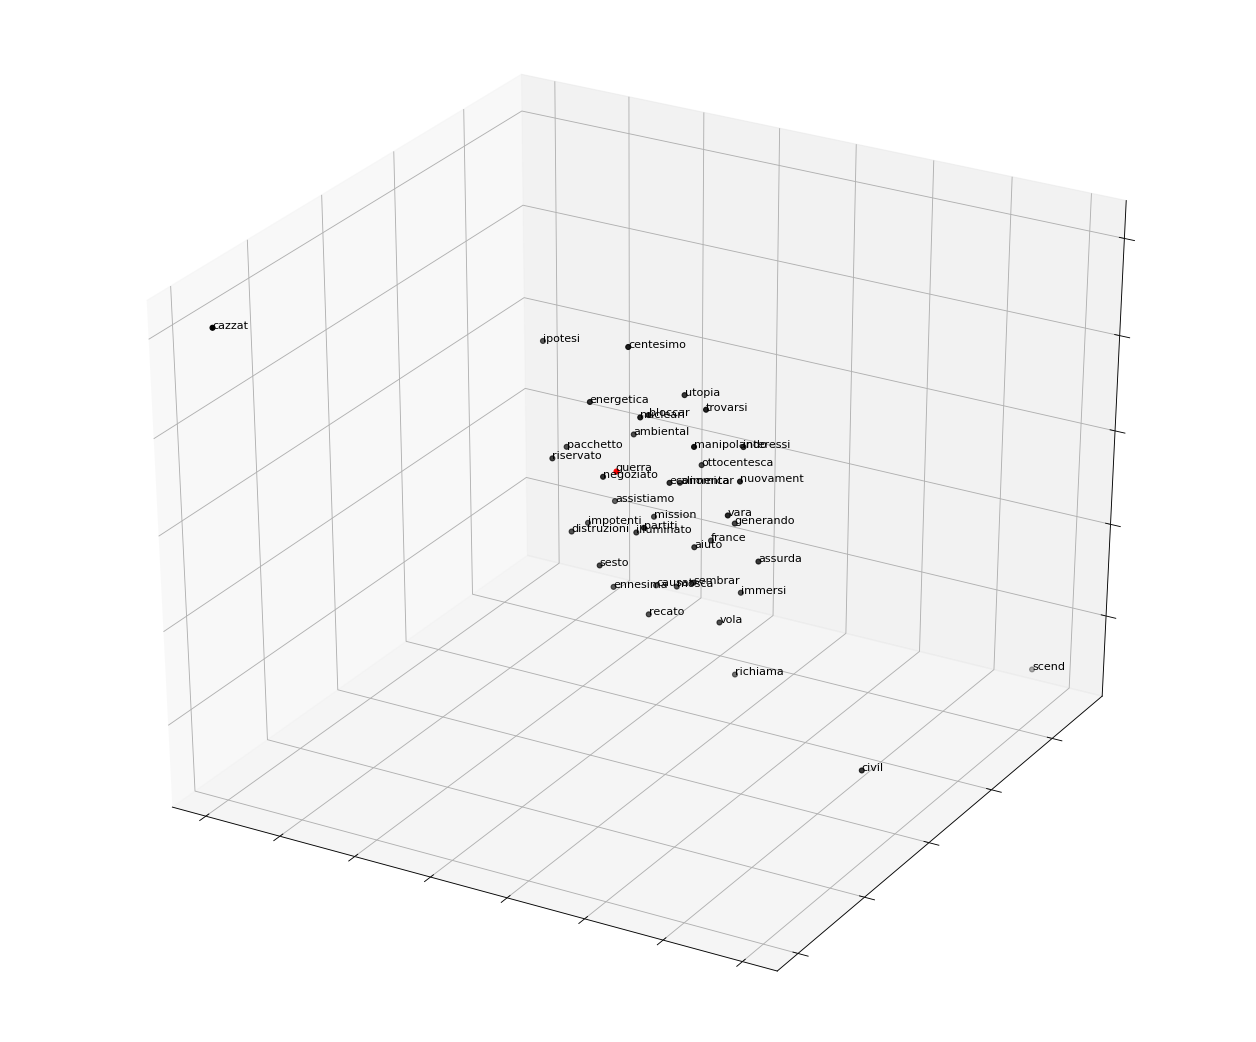

In [20]:
embedding_space_visualization("guerra", embedding_model)

 # **Feature Engineering**

In [21]:
tokenizer = Tokenizer(lower=True, split=' ', oov_token="NaN", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')  # tokenize text
tokenizer.fit_on_texts(lst_corpus)
index_of_words = tokenizer.word_index
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)    ## create sequence
train_x = pad_sequences(lst_text2seq, maxlen=15, padding="post", truncating="post") # pad sequences 

corpus = test_set["text_clean"]

lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

test_x = pad_sequences(lst_text2seq, maxlen=15, padding="post", truncating="post")

In [22]:
print(train_x)
print(len(train_x))
print(test_x)
print(len(test_x))

[[142 735 736 ... 215  86 701]
 [ 84 334 194 ... 277 124 326]
 [ 40  37  42 ...  45  41   4]
 ...
 [240 427 234 ... 291 444 445]
 [  6  14  17 ...  22   7  12]
 [815 875 515 ... 219 122 515]]
3748
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]]
937


# **Embeddings Matrix Building**

In [23]:
embeddings_matrix = np.zeros((len(index_of_words)+1, 300))
for word, idx in index_of_words.items():
    try:
        embeddings_matrix[idx] =  embedding_model[word]
    except:
        pass
print(embeddings_matrix.shape)

(4211, 300)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


# **Labels Encoding**

In [24]:
print("Original Labels: ")
print(train_y)
print(test_y)
lb_train = LabelEncoder()
lb_train.fit(train_y)
train_y = lb_train.transform(train_y)

lb_test = LabelEncoder()
lb_test.fit(test_y)
test_y = lb_test.transform(test_y)

# save label file so we can use in another script
np.save('./train_labels.npy', lb_train.classes_)
np.save('./test_labels.npy', lb_test.classes_)
print("Encoded Labels: ")
print(train_y)
print(test_y)
n_classes = len(np.unique(train_y))

Original Labels: 
['#jeru' '#ANSA' '#Draghi' ... '#ANSA' '#redditodicittadinanza' '#prelemi']
['#Ucraina' '#Draghi' '#Draghi' '#redditodicittadinanza' '#LiveIn'
 '#10lezionidipolitica' '#jeru' '#prelemi' '#redditodicittadinanza'
 '#Draghi' '#redditodicittadinanza' '#Draghi' '#Draghi' '#Ucraina'
 '#3giugno' '#Ucraina' '#4voiceless' '#LiveIn' '#redditodicittadinanza'
 '#jeru' '#4voiceless' '#redditodicittadinanza' '#ANSA'
 '#redditodicittadinanza' '#redditodicittadinanza'
 '#redditodicittadinanza' '#redditodicittadinanza' '#jeru' '#prelemi'
 '#Ucraina' '#Draghi' '#prelemi' '#Draghi' '#redditodicittadinanza'
 '#LiveIn' '#Draghi' '#Draghi' '#4voiceless' '#4voiceless' '#4voiceless'
 '#jeru' '#3giugno' '#Ucraina' '#redditodicittadinanza' '#4voiceless'
 '#Draghi' '#Draghi' '#jeru' '#3giugno' '#10lezionidipolitica'
 '#redditodicittadinanza' '#10lezionidipolitica' '#LiveIn' '#ANSA'
 '#10lezionidipolitica' '#Draghi' '#ANSA' '#redditodicittadinanza' '#ANSA'
 '#Ucraina' '#Ucraina' '#Draghi' '#4voi

# **One-Hot Encoding of Outputs**

In [25]:
print("Original Labels: ")
print(train_y)
print(test_y)
train_y = to_categorical(train_y, num_classes = n_classes)
test_y = to_categorical(train_y, num_classes = n_classes)
print("One-Hot Encoded Labels: ")
print(train_y)
print(test_y)
print(len(train_y))
print(len(test_y))


Original Labels: 
[7 3 4 ... 3 9 8]
[6 4 4 9 5 0 7 8 9 4 9 4 4 6 1 6 2 5 9 7 2 9 3 9 9 9 9 7 8 6 4 8 4 9 5 4 4
 2 2 2 7 1 6 9 2 4 4 7 1 0 9 0 5 3 0 4 3 9 3 6 6 4 2 1 9 8 3 5 0 1 8 8 6 9
 4 6 9 9 6 1 3 6 9 4 4 5 3 9 3 8 7 3 4 6 1 7 5 1 4 7 7 3 6 5 2 2 5 6 5 4 9
 1 2 6 9 4 0 9 0 4 0 0 0 5 4 2 3 7 5 5 0 6 4 9 7 9 9 6 4 2 3 6 4 8 9 9 6 1
 3 5 4 5 9 0 6 4 2 9 4 1 9 4 3 8 1 8 3 1 5 0 4 8 0 7 1 8 3 2 0 0 6 4 4 0 4
 7 9 6 5 4 0 4 6 1 6 3 8 3 9 1 9 5 4 2 9 9 0 0 9 9 5 6 8 4 9 9 0 9 9 8 2 1
 9 6 8 0 1 8 3 5 4 1 4 7 0 4 4 6 5 4 9 5 0 1 4 4 9 7 7 3 7 6 9 4 6 1 4 7 4
 9 9 9 3 5 4 4 9 1 9 9 9 3 2 9 7 2 6 3 9 9 7 4 0 6 9 4 3 4 0 4 3 4 9 6 9 9
 9 5 7 5 5 3 0 9 0 4 4 5 1 9 1 9 1 2 3 6 4 4 9 6 2 5 5 5 0 4 6 4 6 9 6 9 7
 5 4 4 9 2 4 4 7 6 1 8 7 4 1 9 4 4 5 4 1 2 7 9 6 7 0 7 5 3 8 1 1 6 3 2 8 4
 0 3 0 3 1 2 9 9 3 3 1 4 3 2 2 9 4 4 9 9 6 1 2 6 1 1 1 0 9 9 6 4 4 3 9 7 8
 9 9 3 8 5 5 2 4 7 9 4 9 5 5 9 7 7 4 2 2 1 9 8 9 4 7 4 5 7 3 1 0 0 9 8 4 0
 9 9 6 2 6 9 5 4 9 3 4 6 4 4 6 1 0 1 1 9 8 9 8 4 9 1 9 9 1 9 5 3

# **Deep Learning Model Definition**

In [26]:
input = Input(shape=(15,))
x = Embedding(input_dim=embeddings_matrix.shape[0], output_dim=embeddings_matrix.shape[1], weights=[embeddings_matrix], input_length=15, trainable=False)(input)
x = Bidirectional(LSTM(units=15, dropout=0.2, return_sequences=True))(x)
x = Bidirectional(LSTM(units=15, dropout=0.2))(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(input, predictions)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15)]              0         
                                                                 
 embedding (Embedding)       (None, 15, 300)           1263300   
                                                                 
 bidirectional (Bidirectiona  (None, 15, 30)           37920     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 30)               5520      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                1984      
                                                                 
 dense_1 (Dense)             (None, 10)                650   

# **Deep Learning Model Training**

In [27]:
history = training = model.fit(train_x, train_y, batch_size=64, epochs=100, shuffle=True, verbose=1, validation_split=0.2)

Epoch 1/100
47/47 [==============================] - 13s 44ms/step - loss: 1.7637 - accuracy: 0.5260 - val_loss: 1.1695 - val_accuracy: 0.6827
Epoch 2/100
47/47 [==============================] - 1s 13ms/step - loss: 0.8620 - accuracy: 0.7825 - val_loss: 0.5728 - val_accuracy: 0.8387
Epoch 3/100
47/47 [==============================] - 1s 13ms/step - loss: 0.4618 - accuracy: 0.8602 - val_loss: 0.4089 - val_accuracy: 0.8600
Epoch 4/100
47/47 [==============================] - 1s 12ms/step - loss: 0.3391 - accuracy: 0.8836 - val_loss: 0.3587 - val_accuracy: 0.8813
Epoch 5/100
47/47 [==============================] - 1s 13ms/step - loss: 0.2866 - accuracy: 0.8979 - val_loss: 0.3484 - val_accuracy: 0.8867
Epoch 6/100
47/47 [==============================] - 1s 12ms/step - loss: 0.2460 - accuracy: 0.9136 - val_loss: 0.2995 - val_accuracy: 0.9040
Epoch 7/100
47/47 [==============================] - 1s 13ms/step - loss: 0.2248 - accuracy: 0.9273 - val_loss: 0.3139 - val_accuracy: 0.9080
Epoch

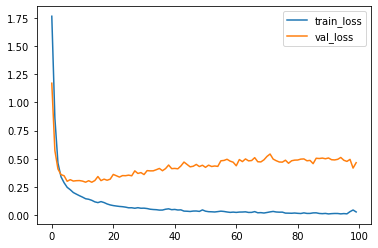

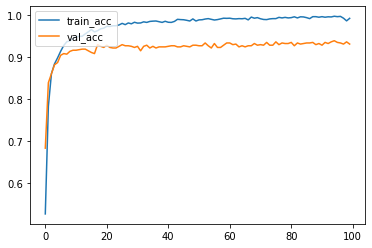

In [34]:
plot_loss(history)
plot_acc(history)

In [36]:
score = model.evaluate(test_x, test_y, batch_size=500)
print(score)

ValueError: ignored